In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
RANDOM_SEED = 42

## 5. Improving a model 

First predictions = baseline predictions.
First model = baseline model.

From a data perspective:
* Could we collect more data? (generally, the more data, the better) 
* Could we improve our data? 

From a model perspective:
* Is there a better model we could use?
* Could we improve the current model? 

Hyperparameters vs. Parameters
* Parameters = model find these patterns in data
* Hyperparameters = settings on a model you can adjust to (potentially) improve its ability to find patterns

Three ways to adjust hyperparameters:
1. By hand
2. Randomly with RandomSearchCV
3. Exhaustively with GridSearchCV

### 5.1 Tuning hyperparameters by hand

Let's make 3 sets, training, validation and test.

We're going to try and adjust:

* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_samples_split`
* `n_estimators`

In [2]:
heart_disease = pd.read_csv("../ztm-ml/data/heart-disease.csv")
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
def evaluate_preds(y_true, y_preds):
    """Perform evaluation comparison on y_true labels vs. y_pred labels on a classification model."""
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)  
    
    metrics_dict = {"accuracy": round(accuracy, 2),
                    "precision": round(precision, 2),
                    "recall": round(recall, 2),
                    "f1": round(f1, 2)}
    
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1: {f1:.2f}%")
    
    return metrics_dict

In [4]:
np.random.seed(RANDOM_SEED)
heart_disease_shuffled = heart_disease.sample(frac=1)
x = heart_disease_shuffled.drop("target", axis=1)
y = heart_disease_shuffled["target"]

train_split = round(0.7 * len(heart_disease_shuffled)) # 70% for training
validation_split = round(train_split + 0.15 * len(heart_disease_shuffled)) # 15% for validation   
x_train, y_train = x[:train_split], y[:train_split]
x_valid, y_valid = x[train_split:validation_split], y[train_split:validation_split]
x_test, y_test = x[validation_split:], y[validation_split:]

len(x_train), len(x_valid), len(x_test)

(212, 45, 46)

In [5]:
np.random.seed(RANDOM_SEED)
clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [6]:
clf.fit(x_train, y_train)
y_preds = clf.predict(x_valid)
baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Accuracy: 0.82%
Precision: 0.84%
Recall: 0.84%
F1: 0.84%


{'accuracy': 0.82, 'precision': 0.84, 'recall': 0.84, 'f1': 0.84}

In [7]:
np.random.seed(RANDOM_SEED)

clf2 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
clf2.fit(x_train, y_train)
y_preds2 = clf2.predict(x_valid)
improved_metrics = evaluate_preds(y_valid, y_preds2)
improved_metrics

Accuracy: 0.82%
Precision: 0.84%
Recall: 0.84%
F1: 0.84%


{'accuracy': 0.82, 'precision': 0.84, 'recall': 0.84, 'f1': 0.84}

In [8]:
np.random.seed(RANDOM_SEED)
clf3 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)
clf3.fit(x_train, y_train)
y_preds3 = clf3.predict(x_valid)
tuned_metrics = evaluate_preds(y_valid, y_preds3)
tuned_metrics

Accuracy: 0.80%
Precision: 0.81%
Recall: 0.84%
F1: 0.82%


{'accuracy': 0.8, 'precision': 0.81, 'recall': 0.84, 'f1': 0.82}

### 5.2 Hyperparameter tuning with RandomizedSearchCV

In [9]:
grid = {
    "n_estimators": [10, 100, 200, 500, 1000, 1200],
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": ["log2", "sqrt"],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4],
}
np.random.seed(RANDOM_SEED)

# Split data into X & y
x = heart_disease_shuffled.drop("target", axis=1)
y = heart_disease_shuffled["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(
    estimator=clf,
    param_distributions=grid,
    n_iter=10,
    cv=5,
    verbose=2,
)

In [10]:
rs_clf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 4, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [11]:
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None}

In [12]:
y_preds = rs_clf.predict(x_test)
rs_metrics = evaluate_preds(y_test, y_preds)

Accuracy: 0.84%
Precision: 0.80%
Recall: 0.86%
F1: 0.83%


### 5.3 Hyperparameter tuning with GridSearchCV

In [13]:
grid2 = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 20],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': [2, 6],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED)

In [14]:
gs_clf = GridSearchCV(
    estimator=clf,
    param_grid=grid2,
    cv=5,
    verbose=2,
)

In [15]:
gs_clf.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2,

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 5, ...], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 6], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [16]:
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [17]:
gs_y_preds = gs_clf.predict(x_test)
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Accuracy: 0.84%
Precision: 0.80%
Recall: 0.86%
F1: 0.83%


In [18]:
gs_metrics

{'accuracy': 0.84, 'precision': 0.8, 'recall': 0.86, 'f1': 0.83}

<Axes: >

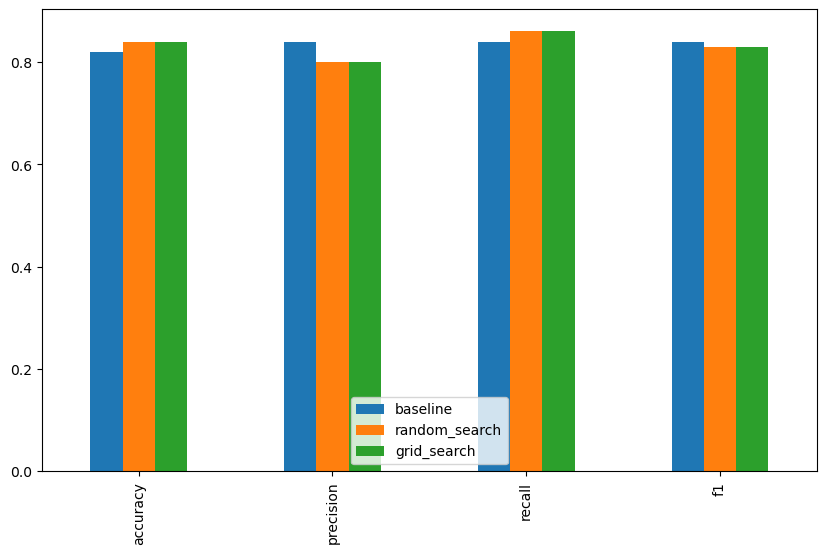

In [19]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "random_search": rs_metrics,
                                "grid_search": gs_metrics})

compare_metrics.plot(kind="bar", figsize=(10, 6), legend=True)


In [25]:
import pickle
pickle.dump(gs_clf, open("save_model/gridsearch_rf1_model.pkl", "wb"))

In [26]:
# Load the model back
loaded_model = pickle.load(open("save_model/gridsearch_rf1_model.pkl", "rb"))

loaded_model_y_preds = loaded_model.predict(x_test)
loaded_model_metrics = evaluate_preds(y_test, loaded_model_y_preds) 

Accuracy: 0.84%
Precision: 0.80%
Recall: 0.86%
F1: 0.83%


In [27]:
import joblib
joblib.dump(gs_clf, "save_model/gridsearch_rf1_model.joblib")

# Load the model back
loaded_model_joblib = joblib.load("save_model/gridsearch_rf1_model.joblib")
loaded_model_joblib_y_preds = loaded_model_joblib.predict(x_test)
loaded_model_joblib_metrics = evaluate_preds(y_test, loaded_model_joblib_y_preds)


Accuracy: 0.84%
Precision: 0.80%
Recall: 0.86%
F1: 0.83%
